In [5]:
import torch
# get Pytorch version
torch.__version__

'1.12.0'

In [6]:
# import torchvision
import torchvision
# get torchvision version
torchvision.__version__

'0.13.0'

In [7]:
# checking if cuda is available
torch.cuda.is_available()
# get number of cuda/gpu devices
torch.cuda.device_count()
# get cuda/gpu device name
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [8]:
from torchvision import datasets

# path to store data and/or load from
path2data="./data"

# loading training data
train_data=datasets.MNIST(path2data, train=True, download=True)

# extract data and targets
x_train, y_train=train_data.data,train_data.targets
print(x_train.shape)
print(y_train.shape)

# loading validation data
val_data=datasets.MNIST(path2data, train=False, download=True)

# extract data and targets
x_val,y_val=val_data.data, val_data.targets
print(x_val.shape)
print(y_val.shape)


torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


torch.Size([60000, 1, 28, 28])
torch.Size([3, 152, 242])


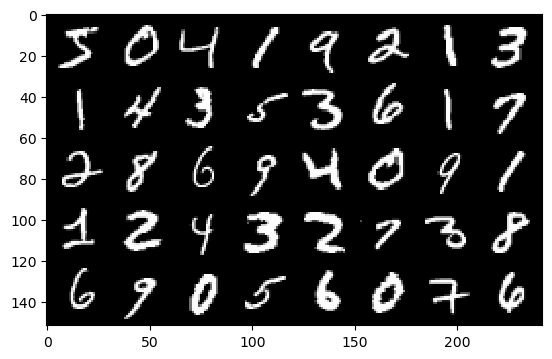

In [9]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# First, add a dimension to tensor to become B*C*H*W
if len(x_train.shape)==3:
    x_train=x_train.unsqueeze(1)
print(x_train.shape)

if len(x_val.shape)==3:
    x_val=x_val.unsqueeze(1)

# make a grid of 40 images, 8 images per row
x_grid=utils.make_grid(x_train[:40], nrow=8, padding=2)
print(x_grid.shape)

# helper function to display images
def show(img):
    # convert tensor to numpy array
    npimg = img.numpy()
    
    # Convert to H*W*C shape
    npimg_tr=np.transpose(npimg, (1,2,0))
    
    # display images
    plt.imshow(npimg_tr,interpolation='nearest')

# call helper function
show(x_grid)


In [10]:
from torchvision import transforms

# loading MNIST training dataset
train_data=datasets.MNIST(path2data, train=True, download=True)

# define transformations
data_transform = transforms.Compose([transforms.ToTensor()])

In [11]:
from torch.utils.data import TensorDataset

# wrap tensors into a dataset
train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)

for x,y in train_ds:
    print(x.shape,y.item())
    break


torch.Size([1, 28, 28]) 5


In [12]:
from torch.utils.data import DataLoader

# create a data loader from dataset
train_dl = DataLoader(train_ds, batch_size=8)
val_dl = DataLoader(val_ds, batch_size=8)

# iterate over batches
for xb,yb in train_dl:
    print(xb.shape)
    print(yb.shape)
    break

torch.Size([8, 1, 28, 28])
torch.Size([8])


In [13]:
from torch import nn

# input tensor dimension 64*1000
input_tensor = torch.randn(64, 1000)

# linear layer with 1000 inputs and 100 outputs
linear_layer = nn.Linear(1000, 100)

# output of the linear layer
output = linear_layer(input_tensor)
print(output.size())

torch.Size([64, 100])


In [14]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, 1)
        self.conv2 = nn.Conv2d(8, 16, 5, 1)
        self.fc1 = nn.Linear(4*4*16, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [15]:
print(next(model.parameters()).device)

cpu


In [16]:
device = torch.device("cuda:0")
model.to(device)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [17]:
!pip install torch-summary

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [18]:
from torchsummary import summary

summary(model, input_size=(1, 28, 28))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            208
├─Conv2d: 1-2                            3,216
├─Linear: 1-3                            25,700
├─Linear: 1-4                            1,010
Total params: 30,134
Trainable params: 30,134
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            208
├─Conv2d: 1-2                            3,216
├─Linear: 1-3                            25,700
├─Linear: 1-4                            1,010
Total params: 30,134
Trainable params: 30,134
Non-trainable params: 0

In [19]:
# define the negative log likelihood loss
loss_func = nn.NLLLoss(reduction="sum")

for xb, yb in train_dl:
    # move batch to cuda device
    xb=xb.type(torch.float).to(device)
    yb=yb.to(device)
    # get model output
    out=model(xb)
    # calculate loss value
    loss = loss_func(out, yb)
    print (loss.item())
    break

80.66171264648438


In [20]:
# compute gradients
loss.backward()

In [21]:
from torch import optim

# define Adam optimizer
opt = optim.Adam(model.parameters(), lr=1e-4)

# update model parameters
opt.step()

# set gradients to zero
opt.zero_grad()


In [22]:
import numpy as np

def metrics_batch(target, output):
    # obtain output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, xb, yb,yb_h, opt=None):
    
    # obtain loss
    loss = loss_func(yb_h, yb)
    
    # obtain performance metric
    metric_b = metrics_batch(yb,yb_h)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), metric_b


def loss_epoch(model,loss_func,dataset_dl,opt=None):
    loss=0.0
    metric=0.0
    len_data=len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb=xb.type(torch.float).to(device)
        yb=yb.to(device)
        
        # obtain model output
        yb_h=model(xb)

        loss_b,metric_b=loss_batch(loss_func, xb, yb,yb_h, opt)
        loss+=loss_b
        if metric_b is not None:
            metric+=metric_b
    loss/=len_data
    metric/=len_data
    return loss, metric



def train_val(epochs, model, loss_func, opt, train_dl, val_dl):
    for epoch in range(epochs):
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,opt)
        
            
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl)
        
        accuracy=100*val_metric

        print("epoch: %d, train loss: %.6f, val loss: %.6f, accuracy: %.2f" %(epoch, train_loss,val_loss,accuracy))


In [23]:
import numpy as np


# call train_val function
num_epochs=10
train_val(num_epochs, model, loss_func, opt, train_dl, val_dl)

epoch: 0, train loss: 0.273209, val loss: 0.103839, accuracy: 96.77
epoch: 1, train loss: 0.083597, val loss: 0.061989, accuracy: 97.96
epoch: 2, train loss: 0.054169, val loss: 0.055188, accuracy: 98.31
epoch: 3, train loss: 0.037377, val loss: 0.052155, accuracy: 98.43
epoch: 4, train loss: 0.027717, val loss: 0.055215, accuracy: 98.31
epoch: 5, train loss: 0.021607, val loss: 0.053897, accuracy: 98.44
epoch: 6, train loss: 0.017376, val loss: 0.068509, accuracy: 98.10
epoch: 7, train loss: 0.013344, val loss: 0.065393, accuracy: 98.24
epoch: 8, train loss: 0.011764, val loss: 0.075614, accuracy: 98.22
epoch: 9, train loss: 0.011069, val loss: 0.074117, accuracy: 98.26


In [24]:
# define path2weights
path2weights="/kaggle/working/weights.pt"

# store state_dict to file
torch.save(model.state_dict(), path2weights)

**Method 1**

In [25]:
 #define model: weights are randomly initiated
_model = Net()

# load weights from file
weights=torch.load(path2weights)

# set weights to model: weights are set with the store values
_model.load_state_dict(weights)

# set model in eval mode for deployment
_model.eval()

# model model to cuda device for accelerated computation
_model.to(device)


Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

**Method 2**

torch.Size([1, 28, 28])
6 6


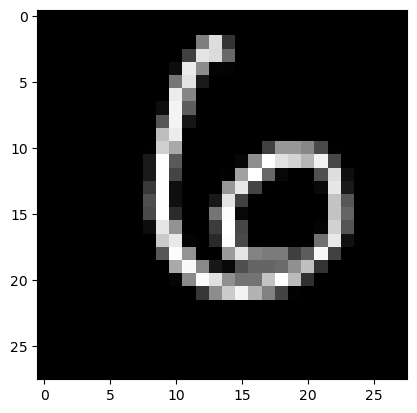

In [26]:
n=100
x= x_val[n]
y=y_val[n]
print(x.shape)
plt.imshow(x.numpy()[0],cmap="gray")

# we use unsqueeze to expand dimensions to 1*C*H*W
x= x.unsqueeze(0)

# convert to torch.float32
x=x.type(torch.float)

# move to cuda device
x=x.to(device)

# get model output
output=_model(x)

# get predicted class
pred = output.argmax(dim=1, keepdim=True)
print (pred.item(),y.item())
